In [1]:
import glob
import pandas as pd
#import random
#import paho.mqtt.client as mqtt
import string
import time
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import integrate

from scipy.constants import c, m_p, e

In [2]:
def synchrotron_momentum(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV
    R0 = 26                         # Mean machine radius
    n_dip = 10                      # Number of dipoles
    dip_l = 4.4                     # Dipole length
    
    dip_angle = 2 * np.pi / n_dip   # Dipole bending angle
    rho = dip_l / dip_angle         # Dipole radius of curvature
    omega = 2 * np.pi * 50   
    
    Ek = np.array([70, max_E]) * 1e6 # Injection and extraction kinetic energies 
    E = Ek + mpeV                    # Injection and extraction kinetic energies
    p = np.sqrt(E**2 - mpeV**2)      # Injection and extraction momenta

    B = p / c / rho                  # Ideal magnetic field at injection and extraction energies
    
    Bdip = lambda t: (B[1] + B[0] - (B[1] - B[0]) * np.cos(omega * t)) / 2  # Idealised B-field variation with AC
    pdip = lambda t: Bdip(t) * rho * c                                      # Momentum from B-field in MeV
    
    return pdip(time*1E-3)

In [3]:
def synchrotron_kinetic_energy(max_E, time):
    mpeV = m_p * c**2 / e           # Proton mass in eV    
    # Relativistic Kinetic Energy = Relativistic Energy - mass
    return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV) # Return array in eV
    #return (np.sqrt(synchrotron_momentum(max_E, time)**2 + mpeV**2) - mpeV)/1E6 # Return array in MeV

In [4]:
# Function to fetch stored unfiltered dataframes

# fetch_stored_data(n, None, False) = R5IM loss data, n = glob file index not BLM index
# fetch_stored_data(n, None, True) = cycle data, n = glob file index not BLM index

def fetch_stored_data(index=0, folder=None, cycle=True):
    
    if folder is None:
        if cycle:
            folder = '../BLM_R5IM_Data/cycle/'
        else:
            folder = '../BLM_R5IM_Data/R5IM_loss/'
    
    if folder[-1] != '/': folder += '/'        
        
    input_data = pd.read_csv(glob.glob(folder + '*.csv')[index])
    return input_data.drop(columns = input_data.columns[0]).to_numpy()

# Eshers Integration

In [5]:
E_max = 800
start = 0
stop = 2200

In [6]:
#np linspace array of the energy ramp of the beam between -0.5 and 10.5 ms with 2200 points
energy_ramp = (synchrotron_kinetic_energy(E_max, (np.linspace(-0.5, 10.5, 2200, endpoint = True))))[start:stop]  

In [7]:
#energy_ramp = (((E_max-70)/2*(np.sin(np.linspace(-0.5, 10.5, 2200)*(np.pi/10)-(np.pi/2))))+(E_max-70)/2+70)[start:stop]
#chris' data
chris_x = [0, 3, 5, 7, 9]
chris_y = [2.22E-16, 2.59E-16, 4.31E-15, 1.60E-14, 3.50E-14]

In [8]:
#chris' calibration curve interpolated over a linspace of 2200 points between -0.5 and 10.5
chris_calibration = np.interp(np.linspace(-0.5, 10.5, 2200), chris_x, chris_y)

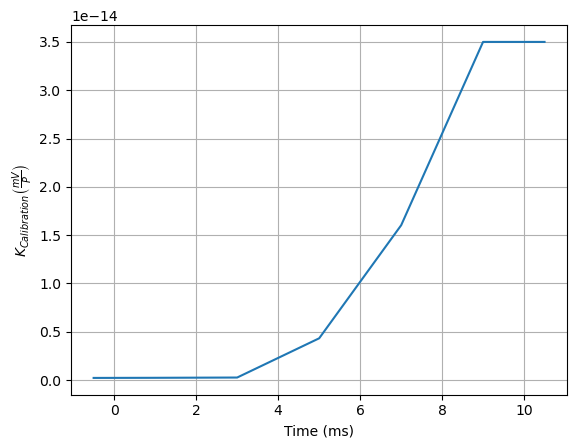

In [24]:
time_array = np.linspace(-0.5, 10.5, len(chris_calibration))
plt.plot(time_array, chris_calibration)
plt.grid()
plt.ylabel(r'$K_{Calibration} \left(\frac{mV}{P}\right)$')
plt.xlabel('Time (ms)');

In [10]:
#chris' calibration curve interpolated in protons/V s
final_calibration = 1/chris_calibration

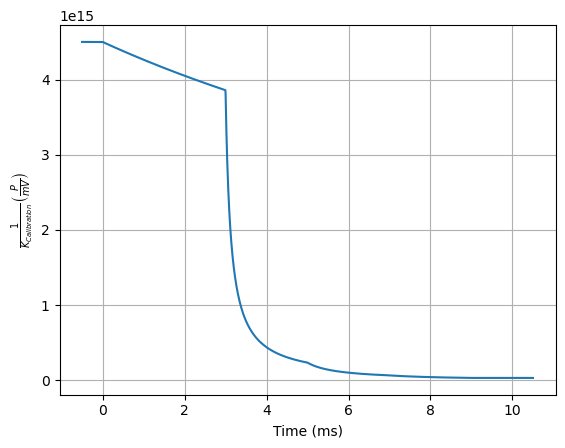

In [26]:
plt.plot(time_array, final_calibration)
plt.grid()
plt.ylabel(r'$\frac{1}{K_{Calibration}} \left(\frac{P}{mV}\right)$')
plt.xlabel('Time (ms)');

In [12]:
data = fetch_stored_data(0, None, False)[1:38]

In [13]:
# relevant calibration curve between start and stop time periods
# The calibration constant before 0 seconds should be zero - as the losses from the BLMs should be discounted during this period
# final_calibration[0:find_nearest(np.linspace(-0.5, 10.5, num=2200), 0)] = 0
calibration_curve = final_calibration[start:stop]
blm_sum = np.sum(data, axis = 0)

In [14]:
blm_sum

array([-0.06589, -0.02623, -0.02258, ..., -0.0726 , -0.07077, -0.07504])

In [15]:
#sum_1 gives the relevant blm sum signal as an array betwen the start and stop time periods 
sum_1 = blm_sum[start:stop]

In [16]:
#cumulative_sum sums the trapezoids cumulatively in an increasing array. 
#we need to find the difference between consecutive values to find the integrals of each bin
cumulative_sum = integrate.cumulative_trapezoid(sum_1, x = np.linspace(-0.5, 10.5, 2200)[start:stop])

In [17]:
#integrated_sum is an array of all integrated bins between start and stop
integrated_sum = [0]
integrated_sum[0] = cumulative_sum[0]
for i in range(1, len(cumulative_sum)):
    integrated_sum.append((cumulative_sum[i]-cumulative_sum[i-1]))

In [18]:
#remember to change from s to ms
# integrated bins in Vms divided by 1000 to get Vs and multiplying by calibration constants to get number of protons
#print(len(protons))
protons_per_bin = ((np.array(integrated_sum))*0.001*(np.delete(calibration_curve, [0])))

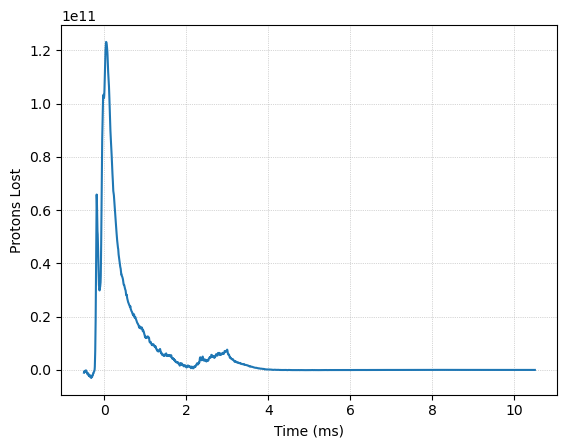

In [19]:
time_array = np.linspace(-0.5, 10.5, len(protons_per_bin))
plt.plot(time_array, protons_per_bin);
plt.ylabel('Protons Lost');
plt.xlabel('Time (ms)');
plt.grid(which='both', ls=':', lw=0.5)